# Semantic Segmentation

### Import frameworks, libraries and modules

In [1]:
import os
import numpy as np
import as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy import io

In [2]:
# Use tf.test.is_built_with_cuda() to validate if TensorFlow was built with CUDA support.
tf.test.is_built_with_cuda()

False

# Download and prepare data

### Download masks

In [3]:
path_mask_folder = os.path.pardir+os.sep+'lib'+os.sep+'MASKS'
path_mask_folder

'../lib/MASKS'

In [4]:
mask_path = []

for root, dirs, files in os.walk(path_mask_folder):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
len(mask_path)

1003

### Download images

In [5]:
path_images_folder = os.path.pardir+os.sep+'lib'+os.sep+'IMAGES'
path_images_folder

'../lib/IMAGES'

In [6]:
image_path_ = []

for root, dirs, files in os.walk(path_images_folder):
    for file in files:
        path = os.path.join(root,file)
        image_path_.append(path)
len(image_path_)

2097

### Sorting the masks to match the image

In [7]:
mask_path.sort()

In [8]:
image_path_.sort()

### Separating the training set associated with the masks

In [9]:
image_path = image_path_[:len(mask_path)]

In [10]:
len(image_path)

1003

### Reading masks and images

In [11]:
%%time

images = []

for path in image_path:
    file = tf.io.read_file(path)
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    images.append(image)

masks = []

for path in mask_path:
    file = tf.io.read_file(path)
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    masks.append(mask)

CPU times: user 12.3 s, sys: 1.13 s, total: 13.4 s
Wall time: 14.8 s


### Sample few images and visualize

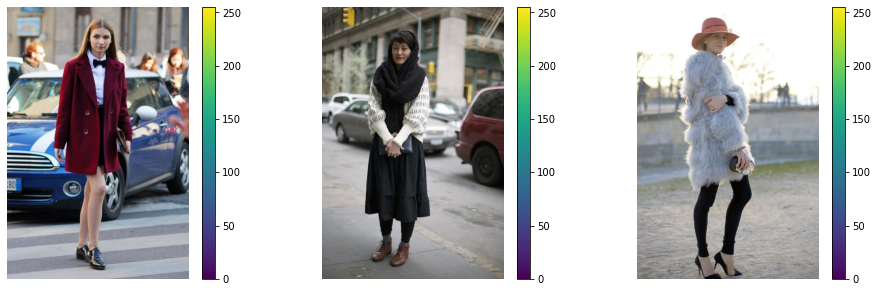

In [12]:
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[60+i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

Изображения ярлыков имеют 59 сегментированных классов, 
соответствующих таким классам, как волосы, сумка, рубашка, обувь, кожа, 
солнцезащитные очки и кепка.

### Sample corresponding masks and visualize

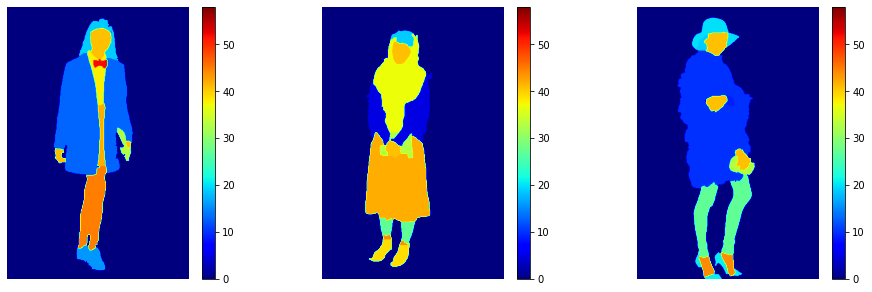

In [13]:
norm = mpl.colors.Normalize(vmin=0, vmax=58)

plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[60+i]
    plt.imshow(img, cmap='jet', norm=norm)
    plt.colorbar()
    plt.axis('off')
plt.show()

### Download masks label

In [14]:
path_pixel_level = os.path.pardir+os.sep+'lib'+os.sep+'clothing-co-parsing' \
                                                        +os.sep+'annotations'+os.sep+'pixel-level'
path_pixel_level

'../lib/clothing-co-parsing/annotations/pixel-level'

In [15]:
pixel_level_of_images = []

for root, dirs, files in os.walk(path_pixel_level):
    pixel_level_of_images.append(len(files))
    
segmentations = []

for i in range(1,pixel_level_of_images[0]+1):
    
    url = path_pixel_level+os.sep+ '%04d.mat'%(i)
    
    # Чтение файлов .ma
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    # resize ожидает 3D-изображения, но мы получили 2D-изображение в оттенках серого
    mask = tf.expand_dims(mask,-1)
    mask = tf.image.resize_with_crop_or_pad(mask,825,550)
    segmentations.append(mask)
    
list_unique_mask = np.unique(tf.squeeze(segmentations))

if min(list_unique_mask)==0:
    num_mask = max(list_unique_mask)+1

## Build Downstack with a Pre-trained CNN

In [16]:
DenseNet121_base = keras.applications.DenseNet121(input_shape=[128,128,3], 
                                      include_top=False, 
                                      weights='imagenet')

### How many layers does this model have?

In [17]:
len(DenseNet121_base.layers)

427

Нам нужно определить подходящие слои, вывод которых будет использоваться для пропуска соединений.  
Выбираем слои активации ReLU для каждого размера карты функций, то есть 4, 8, 16, 32 и 64, необходимых для пропуска подключений.

In [18]:
DenseNet121_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [19]:
skip_names = []
for layer in tuple(DenseNet121_base.layers):
        layer_type = type(layer).__name__
        if hasattr(layer, 'activation'):
            if layer_type != "Conv2D":   
                if not layer.name.__contains__('block'):
                    skip_names.append(layer.name) 

In [20]:
skip_names

['conv1/relu', 'pool2_relu', 'pool3_relu', 'pool4_relu', 'relu']

### Obtain the outputs of these layers.

In [21]:
skip_outputs = [] 

for name in skip_names:
    relu = DenseNet121_base.get_layer(name).output
    print('{} : {}'.format(name, relu.shape))
    skip_outputs.append(relu)

conv1/relu : (None, 64, 64, 64)
pool2_relu : (None, 32, 32, 256)
pool3_relu : (None, 16, 16, 512)
pool4_relu : (None, 8, 8, 1024)
relu : (None, 4, 4, 1024)


### Build the downstack with the above layers. 

In [22]:
downstack = keras.Model(inputs=DenseNet121_base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

# Build Upstack

### Build the up stack using  pix2pix

In [23]:
# !pip install -q git+https://github.com/tensorflow/examples.git

In [24]:
from tensorflow_examples.models.pix2pix import pix2pix

In [25]:
# Four upstack layers for upsampling sizes 
# 4->8, 8->16, 16->32, 32->64 
up_stack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [26]:
up_stack[0].layers

# Build U-Net model with skip-connections

In [27]:
OUTPUT_CHANNELS = 3

In [28]:
def Model(up_stack, downsample):
    
    inputs = keras.layers.Input(shape=[128,128,3])
    
    down = downstack(inputs)
    out = down[-1]

    # prepare skip-connections
    skips = reversed(down[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        out = up(out)
        out = tf.keras.layers.Concatenate()([out, skip])
        
    initializer = tf.random_normal_initializer(0., 0.02)
    # image 128 by 128 with 59 classes
    out = keras.layers.Conv2DTranspose(num_mask, OUTPUT_CHANNELS,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')(out)  # (batch_size, 128, 128, 3)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy']) 

    return model

In [29]:
unet = Model(up_stack, downstack)

### Let's plot our model

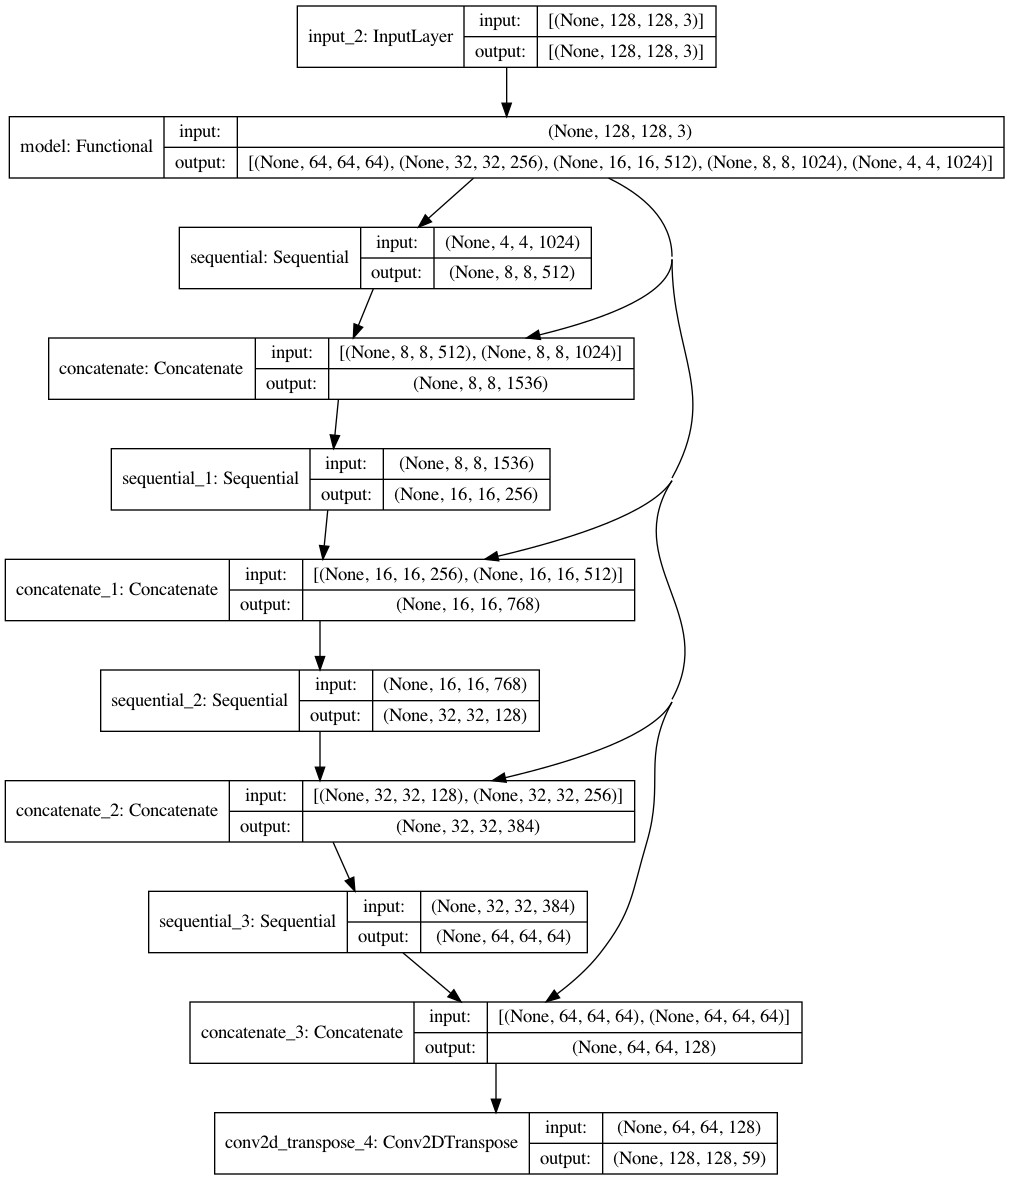

In [30]:
keras.utils.plot_model(unet, show_shapes=True)

# Data Preprocessing

In [31]:
images[0].shape, masks[0].shape

(TensorShape([825, 550, 3]), TensorShape([825, 550, 1]))

### Resize data as the model expects. 

In [32]:
def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [33]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1003, 1003)

In [34]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

### Visualize a resized image and a resized mask

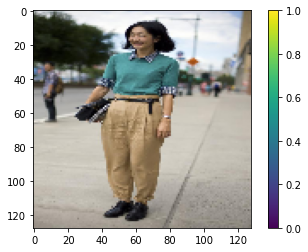

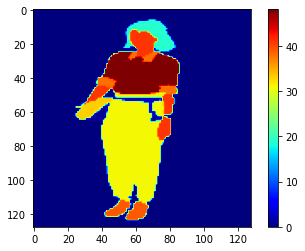

In [48]:
# plot an image
plt.imshow(X[57])
plt.colorbar()
plt.show()

#plot a mask
plt.imshow(y[57], cmap='jet')
plt.colorbar()
plt.show()

# Split Data for training and validation

Разделим данные на набор для обучения и проверки в соотношении 80/20.  
Обвернем данные в  объекты TensorFlow Dataset для обучающих и проверочных наборов, чтобы упростить дальнейшую обработку данных.

In [49]:
from sklearn.model_selection import train_test_split
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )
# С помощью tf.data.Dataset.from_tensor_slices() метода мы можем получить срезы массива
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

# Data Augmentation 

У нас меньше данных (всего 800 примеров в обучающей выборке), которых недостаточно для глубокого обучения. Следовательно, мы должны увеличить объем обучающих данных, выполняя приращения данных. Определим функции для увеличения данных.

In [50]:
def brightness(img, mask):
    # adjust brightness of image
    # don't alter in mask
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    # adjust gamma of image
    # don't alter in mask
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    # adjust hue of image
    # don't alter in mask
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    # rotate both image and mask identically
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

Объединим исходный обучающий набор с расширенным новым набором. Не выполняйте увеличение данных с набором проверки.   
У нас есть 7 функций и 800 примеров ввода. 7 * 800 = 5600 новых примеров.  
Включая оригинальные примеры, получаем 5600 + 800 = 6400 примеров для обучения.  

In [51]:
# zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

## Efficient training

In [52]:
BATCH = 64

BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

#### cache

Кэширует элементы в этом наборе данных.  

При первом повторении набора данных его элементы будут кэшироваться либо в указанном файле, либо в памяти.  
Последующие итерации будут использовать кешированные данные.  

#### shuffle

Случайным образом перемешивает элементы этого набора данных.  

Этот набор данных заполняет буфер `buffer_size` элементами, а затем произвольно  
выбирает элементы из этого буфера, заменяя выбранные элементы новыми элементами.   
Для идеального перемешивания требуется размер буфера больше или равный полному размеру набора данных.  

`reshuffle_each_iterati` onопределяет, должен ли порядок воспроизведения быть разным для каждой эпохи.  

#### batch

Объединяет последовательные элементы этого набора данных в пакеты.  

#### prefetch

Создает объект, Datasetкоторый предварительно выбирает элементы из этого набора данных.  
Если используется значение `tf.data.AUTOTUNE` размер буфера настраивается динамически.

In [53]:
train = train.cache()
train = train.shuffle(buffer_size = BUFFER, reshuffle_each_iteration=True)
train = train.batch(batch_size = BATCH)
train = train.repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

val = val.batch(batch_size = BATCH)

# Compiling Model

In [54]:
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy']) 
Compile_Model()

# Training and Fine-tuning

In [78]:
# path_model = os.path.pardir+os.sep+'models'
# path_model

In [79]:
# imported = tf.saved_model.load(path_model)
# outputs = imported(inputs)

In [108]:
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=50,
               verbose=2)

Epoch 1/50
12/12 - 55s - loss: 3.2515 - accuracy: 0.5977 - val_loss: 3.4555 - val_accuracy: 0.1108
Epoch 2/50
12/12 - 49s - loss: 2.7334 - accuracy: 0.7683 - val_loss: 3.2352 - val_accuracy: 0.4994
Epoch 3/50
12/12 - 49s - loss: 2.6089 - accuracy: 0.7756 - val_loss: 2.9335 - val_accuracy: 0.6878
Epoch 4/50
12/12 - 49s - loss: 2.6616 - accuracy: 0.7077 - val_loss: 2.7420 - val_accuracy: 0.7741
Epoch 5/50
12/12 - 49s - loss: 2.6134 - accuracy: 0.7210 - val_loss: 2.6368 - val_accuracy: 0.7794
Epoch 6/50
12/12 - 49s - loss: 2.5461 - accuracy: 0.7565 - val_loss: 2.5951 - val_accuracy: 0.7790
Epoch 7/50
12/12 - 50s - loss: 2.5051 - accuracy: 0.7724 - val_loss: 2.5475 - val_accuracy: 0.7777
Epoch 8/50
12/12 - 49s - loss: 2.4779 - accuracy: 0.7745 - val_loss: 2.5176 - val_accuracy: 0.7754
Epoch 9/50
12/12 - 47s - loss: 2.4510 - accuracy: 0.7818 - val_loss: 2.4828 - val_accuracy: 0.7772
Epoch 10/50
12/12 - 49s - loss: 2.4271 - accuracy: 0.7892 - val_loss: 2.4831 - val_accuracy: 0.7760
Epoch 11/

### Make some prediction and visualize them to evaluate the model qualitatively.

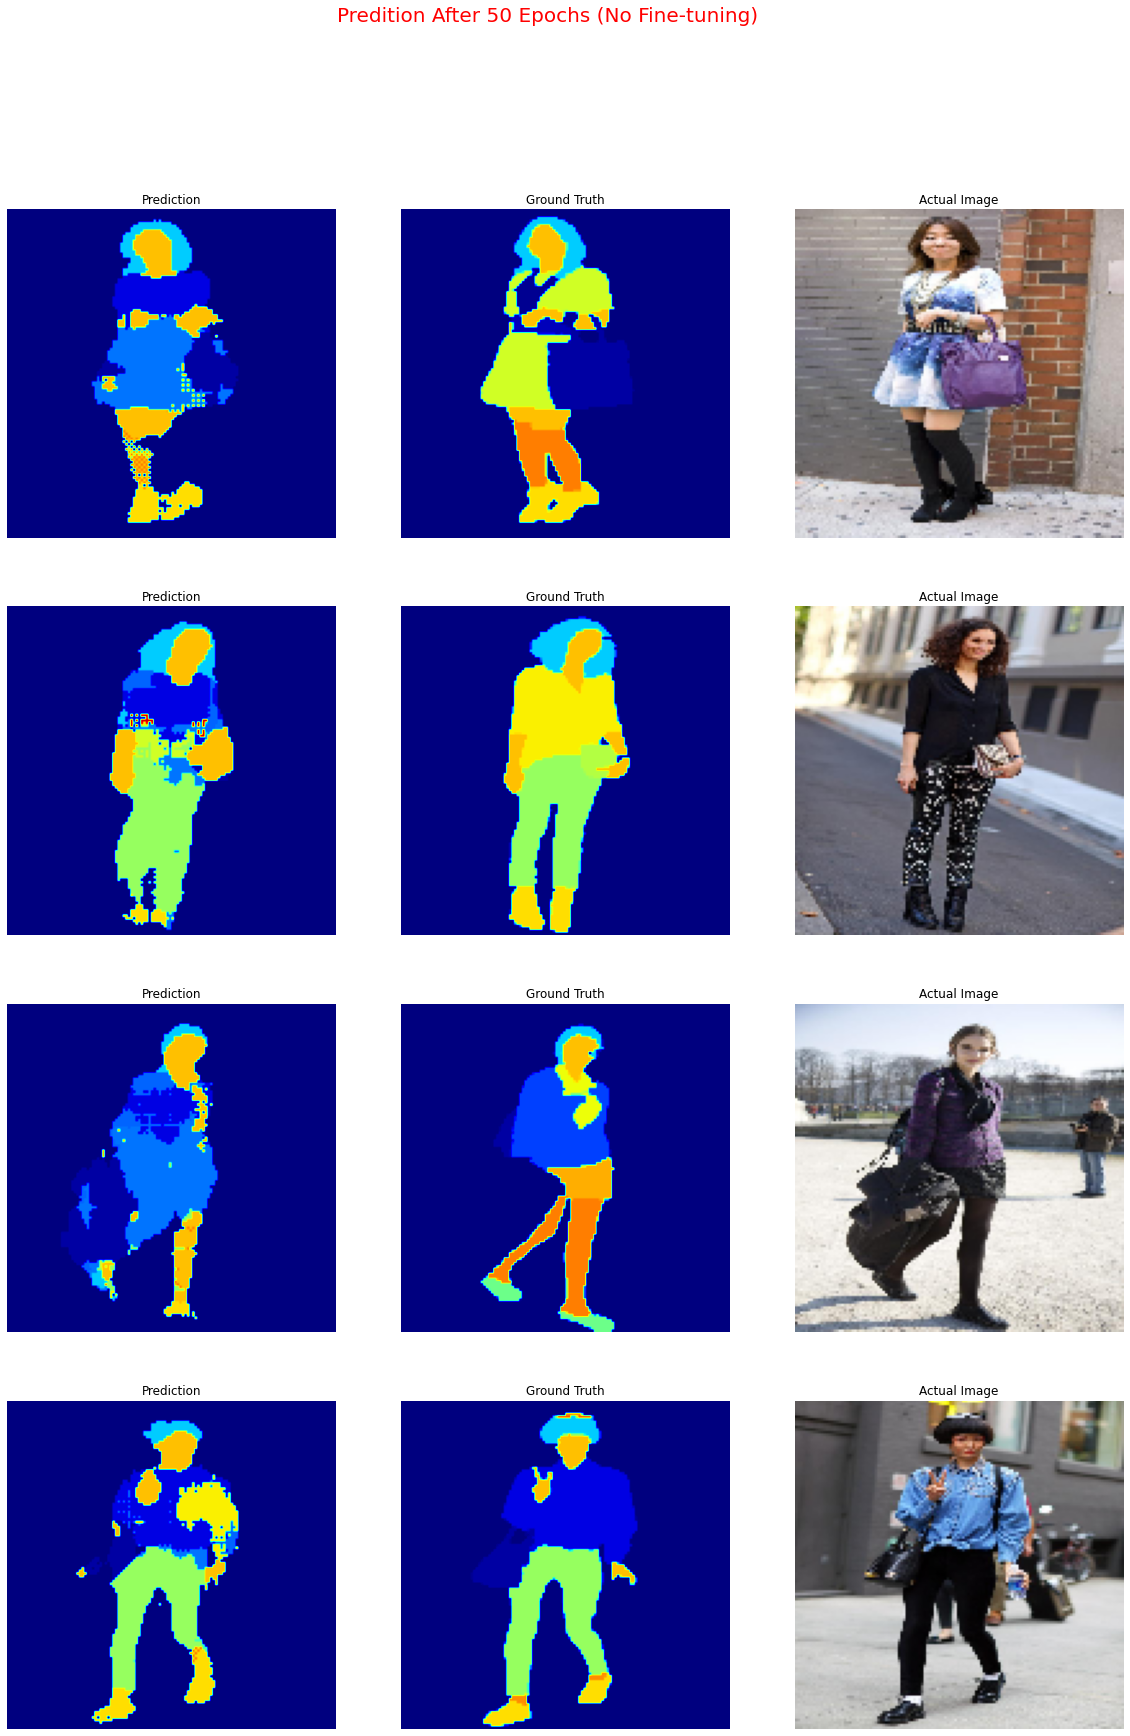

In [109]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Prediction')
    
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 50 Epochs', size=20)  
plt.show()

### Fine-tune the model after 50 epochs. Unfreeze the downstack, compile the model once again. Re-train it for 100 more epochs.

In [111]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 51 to 100
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=100, initial_epoch = 50,
               verbose = 2)

Epoch 51/100
12/12 - 135s - loss: 2.2914 - accuracy: 0.8888 - val_loss: 2.4024 - val_accuracy: 0.8509
Epoch 52/100
12/12 - 119s - loss: 2.2691 - accuracy: 0.9066 - val_loss: 2.3991 - val_accuracy: 0.8554
Epoch 53/100
12/12 - 116s - loss: 2.2679 - accuracy: 0.9081 - val_loss: 2.3901 - val_accuracy: 0.8617
Epoch 54/100
12/12 - 116s - loss: 2.3408 - accuracy: 0.8591 - val_loss: 2.4179 - val_accuracy: 0.8460
Epoch 55/100
12/12 - 119s - loss: 2.3361 - accuracy: 0.8610 - val_loss: 2.3887 - val_accuracy: 0.8644
Epoch 56/100
12/12 - 118s - loss: 2.3142 - accuracy: 0.8743 - val_loss: 2.3856 - val_accuracy: 0.8588
Epoch 57/100
12/12 - 118s - loss: 2.3093 - accuracy: 0.8770 - val_loss: 2.3924 - val_accuracy: 0.8460
Epoch 58/100
12/12 - 120s - loss: 2.3119 - accuracy: 0.8740 - val_loss: 2.4043 - val_accuracy: 0.8455
Epoch 59/100
12/12 - 110s - loss: 2.2750 - accuracy: 0.9020 - val_loss: 2.3920 - val_accuracy: 0.8645
Epoch 60/100
12/12 - 117s - loss: 2.2567 - accuracy: 0.9181 - val_loss: 2.3874 - v

# Prediction

### The model is trained. Make prediction and visualize the output. 

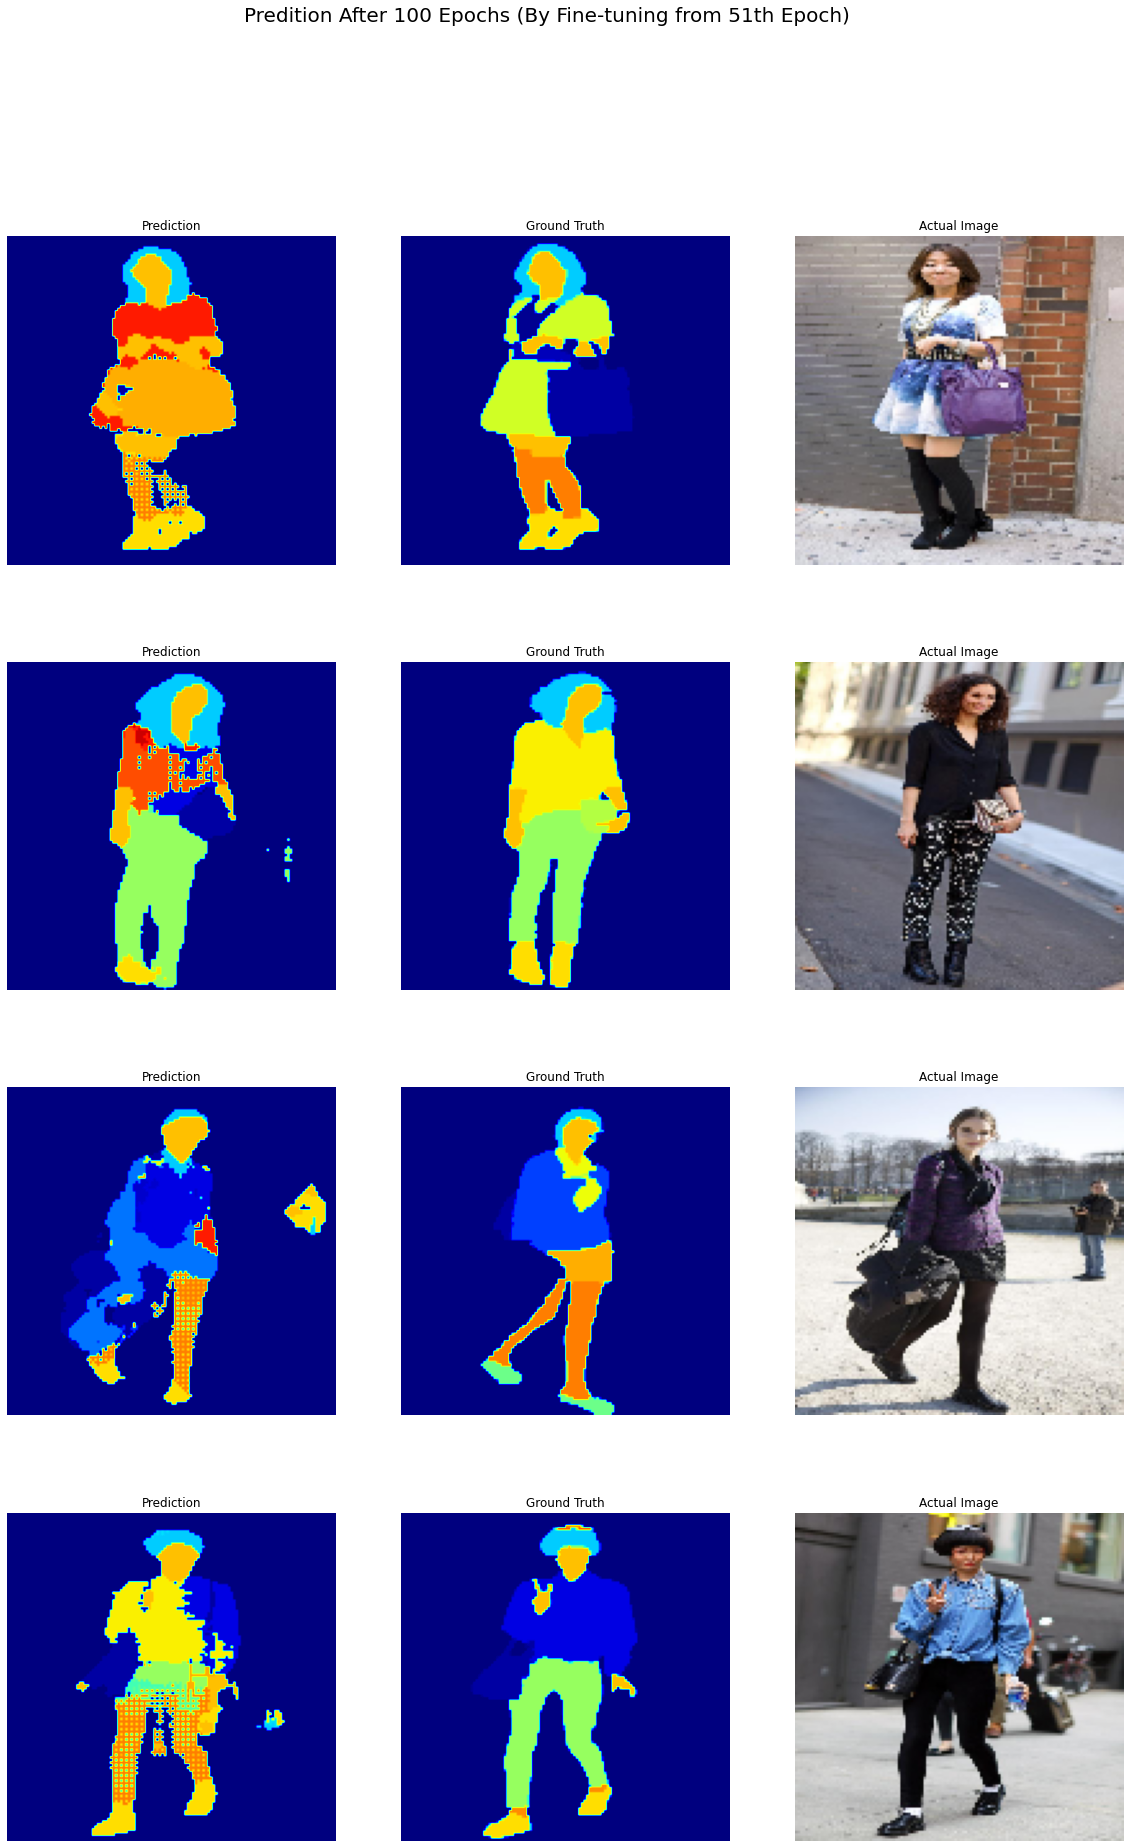

In [115]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Prediction')
    
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 100 Epochs (By Fine-tuning from 51th Epoch)', size=20)  
plt.show()

### Fine-tuning has improved the model performance significantly!

# Performance Curves

### Plot the performance curves to understand how the model learnt on the data 

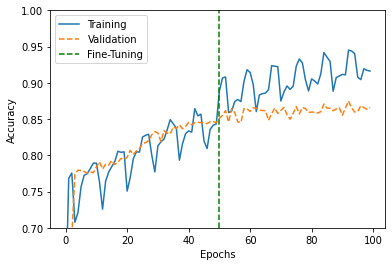

In [116]:
history_1 = hist_1.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']

history_2 = hist_2.history
acc.extend(history_2['accuracy'])
val_acc.extend(history_2['val_accuracy'])

plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.plot([50,50],[0.7,1.0], '--g', label='Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

# Saving model

In [117]:
mobilenet_save_path = os.path.pardi r+os.sep+ 'models'
tf.saved_model.save(unet, mobilenet_save_path)

INFO:tensorflow:Assets written to: ..\lib\models\assets


In [118]:
path_weights = os.path.pardir +os.sep+ 'models' +os.sep+ 'weights' +os.sep+ 'unet_weights.h5' 

In [119]:
unet.save_weights(path_weights)